In [29]:
# read csv file and clean the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

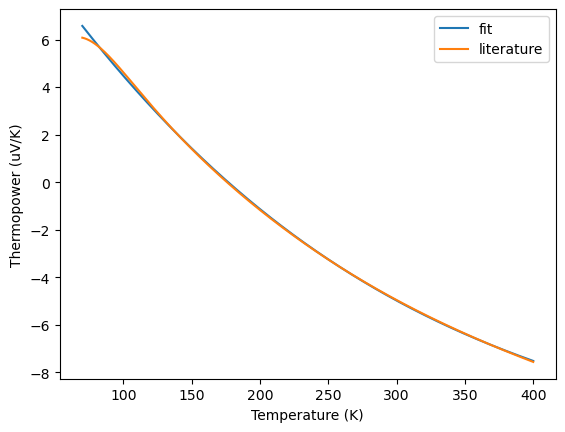

In [64]:
# literature values
# thermopower of platinum

# plot the literature values
plt.figure()
T = np.linspace(70, 400, 1000)
S_Pt = 0.186 * T * (np.exp(-(T/88)) - 0.0786 + (0.43 / (1 + (T / 84.3) ** 4))) - 2.57

# fit S_Pt using a third order polynomial
# fit the data
p = np.polyfit(T, S_Pt, 3)
S_Pt_fit = np.polyval(p, T)

plt.plot(T, S_Pt_fit, label='fit')
plt.plot(T, S_Pt, label='literature')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermopower (uV/K)')
plt.legend()
plt.show()

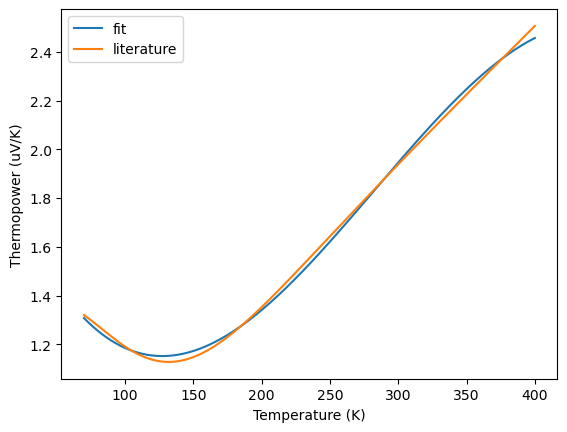

In [65]:
# literature values
# thermopower of copper

# plot the literature values
plt.figure()
T = np.linspace(70, 400, 1000)
S_Cu = 0.041 * T * (np.exp(-T/93) + 0.123 - (0.442)/(1 + (T / 172.4)**3)) + 0.804

# fit S_Cu using a third order polynomial
# fit the data
p = np.polyfit(T, S_Cu, 3)
S_Cu_fit = np.polyval(p, T)

plt.plot(T, S_Cu_fit, label='fit')
plt.plot(T, S_Cu, label='literature')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermopower (uV/K)')
plt.legend()
plt.show()

In [32]:
def read_csv(file_path):
    """
    Read csv file and return a pandas dataframe
    
    Parameters:
    file_path: str, path to the csv file
    
    Returns:
    data: pandas dataframe
    """
    data = pd.read_csv(file_path)
    return data

In [33]:
# calculate the temperature from the resistance of a PT100
def PT100_Temperature(PT100_Resistance):
    A = 3.9083e-3
    B = -5.775e-7
    R0 = 100.0
    T = (-R0 * A + np.sqrt(R0**2 * A**2 - 4 * R0 * B * (R0 - PT100_Resistance))) / (2 * R0 * B)
    return T


def PT100_Resistance(V_in, V_diff, R1, R2):
    num = R1 * (R2/(R1+R2) + V_diff/V_in)
    den = 1 - (R2/(R1+R2) + V_diff/V_in)
    return num/den


In [34]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def smooth_column(data, cutoff, column, order=5):
    """
    Smooth the voltage data using a butterworth filter
    Parameters:
    data: a pandas dataframe with a column which should be smoothed
    cutoff: the cutoff frequency (Hz)
    order: the order of the filter (default 5)

    Returns:
    the smoothed data as a pandas dataframe
    """

    # check if the data has a voltage column
    if column not in data.columns:
        raise ValueError('The data does not have the specified column')
    
    data_smoothed = data.copy()

    fs = 1.0 / (data_smoothed['Time'][10001] - data_smoothed['Time'][10000])

    # name of the column to smooth
    data_smoothed[column + '_lowpass'] = butter_lowpass_filter(data[column], cutoff, fs, order)
    return data_smoothed

def compute_gradient(data, drop_first_last=5000):
    """
    Compute the gradient of the data with respect to temperature
    Parameters:
    data: a pandas dataframe with a Temperature column
    drop_first_last: the number of values to drop from the start and end of the gradient (default 5000)
    
    Returns:
    the gradient of the voltage with respect to temperature
    """

    # check if the data has a Temperature column
    if 'Temperature' not in data.columns:
        raise ValueError('The data does not have a Temperature column')
    
    # check if the data has a Voltage column
    if 'Voltage' not in data.columns:
        raise ValueError('The data does not have a Voltage column')
    
    gradient_column = np.gradient(data['Voltage']) #dV/da
    gradient_temperature = np.gradient(data['Temperature']) #dt/da
    gradient = gradient_column / gradient_temperature
    # replace inf with nan
    #gradient = np.where(gradient == np.inf, np.nan, gradient)
    #gradient = np.where(abs(gradient) >= 0.1, np.nan, gradient)

    # drop the first and last values
    #gradient = gradient[drop_first_last:-drop_first_last]

    return gradient

In [35]:
Kupfer_Konstantan = read_csv('data_combined/Kupfer_Konstantan_Full_Range.csv')
Kupfer_Nickel = read_csv('data_combined/Kupfer_Nickel_Full_Range.csv')

Kupfer_Konstantan['V_R'] = Kupfer_Konstantan['V_R']/1000
Kupfer_Nickel['V_R'] = Kupfer_Nickel['V_R']/1000

Kupfer_Konstantan['V_T'] = Kupfer_Konstantan['V_T']/1000
Kupfer_Nickel['V_T'] = Kupfer_Nickel['V_T']/1000

Kupfer_Konstantan['Resistance'] = PT100_Resistance(5.017, Kupfer_Konstantan['V_R'], 2200, 100)
Kupfer_Konstantan['Temperature'] = PT100_Temperature(PT100_Resistance(5.017, Kupfer_Konstantan['V_R'], 2200, 100)) + 273.15
Kupfer_Nickel['Resistance'] = PT100_Resistance(5.017, Kupfer_Nickel['V_R'], 2200, 100)
Kupfer_Nickel['Temperature'] = PT100_Temperature(PT100_Resistance(5.017, Kupfer_Nickel['V_R'], 2200, 100)) + 273.15

# remove the first and last 5000 values
drop_first_last = 50
Kupfer_Konstantan = Kupfer_Konstantan[drop_first_last:-drop_first_last]
Kupfer_Nickel = Kupfer_Nickel[drop_first_last:-drop_first_last]

In [36]:
# move a sliding window of 1000 values and remove all temperature values that are more than 5 degrees from the mean temperature in the window
window_size = 1000
window_step = 1000
window_start = 0
window_end = window_size

Kupfer_Konstantan['Temperature_filtered'] = np.nan

while window_end < len(Kupfer_Konstantan):
    mean_temperature = np.mean(Kupfer_Konstantan['Temperature'][window_start:window_end])
    Kupfer_Konstantan['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Konstantan['Temperature'][window_start:window_end] - mean_temperature) > 5, np.nan, Kupfer_Konstantan['Temperature'][window_start:window_end])
    
    window_start += window_step
    window_end += window_step

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_44870/806247883.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Kupfer_Konstantan['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Konstantan['Temperature'

In [37]:
window_size = 1000
window_step = 1000
window_start = 0
window_end = window_size

Kupfer_Nickel['Temperature_filtered'] = np.nan

while window_end < len(Kupfer_Nickel):
    mean_temperature = np.mean(Kupfer_Nickel['Temperature'][window_start:window_end])
    Kupfer_Nickel['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Nickel['Temperature'][window_start:window_end] - mean_temperature) > 5, np.nan, Kupfer_Nickel['Temperature'][window_start:window_end])

    window_start += window_step
    window_end += window_step

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_44870/3094878943.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Kupfer_Nickel['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Nickel['Temperature'][windo

In [38]:
#replace nan values with the closest non-nan value
Kupfer_Konstantan['Temperature_filtered'] = Kupfer_Konstantan['Temperature_filtered'].interpolate(method='nearest')
Kupfer_Nickel['Temperature_filtered'] = Kupfer_Nickel['Temperature_filtered'].interpolate(method='nearest')

In [39]:
Kupfer_Konstantan = smooth_column(Kupfer_Konstantan, 3, 'Temperature_filtered')
Kupfer_Nickel = smooth_column(Kupfer_Nickel, 3, 'Temperature_filtered')

Kupfer_Konstantan = smooth_column(Kupfer_Konstantan, 2, 'V_T')
Kupfer_Nickel = smooth_column(Kupfer_Nickel, 2, 'V_T')

# smooth the data using the mean of a sliding window of 1000 values
Kupfer_Konstantan['Temperature_filtered_sliding_window'] = Kupfer_Konstantan['Temperature_filtered'].rolling(window=100).mean()
Kupfer_Nickel['Temperature_filtered_sliding_window'] = Kupfer_Nickel['Temperature_filtered'].rolling(window=100).mean()

#Kupfer_Konstantan['Gradient'] = compute_gradient(Kupfer_Konstantan)
#Kupfer_Nickel['Gradient'] = compute_gradient(Kupfer_Nickel)

#Kupfer_Konstantan = smooth_column(Kupfer_Konstantan, 20, 'V_R')
#Kupfer_Nickel = smooth_column(Kupfer_Nickel, 20, 'V_R')

# drop the first and last 50 values
drop_first_last = 5000
Kupfer_Konstantan = Kupfer_Konstantan[drop_first_last:-drop_first_last]
Kupfer_Nickel = Kupfer_Nickel[drop_first_last:-drop_first_last]

In [69]:
# find a polynomial fit for the data for a range of degrees
polynomials_k_k = []
errors_k_k = []

polynomials_k_n = []
errors_k_n = []

for i in range(4, 5):
    p = np.polyfit(Kupfer_Konstantan['Temperature_filtered_lowpass'], Kupfer_Konstantan['V_T'], i)
    polynomials_k_k.append(p)
    error = np.mean((np.polyval(p, Kupfer_Konstantan['Temperature_filtered_lowpass']) - Kupfer_Konstantan['V_T'])**2)
    errors_k_k.append(error)

    p = np.polyfit(Kupfer_Nickel['Temperature_filtered_lowpass'], Kupfer_Nickel['V_T'], i)
    polynomials_k_n.append(p)
    error = np.mean((np.polyval(p, Kupfer_Nickel['Temperature_filtered_lowpass']) - Kupfer_Nickel['V_T'])**2)
    errors_k_n.append(error)

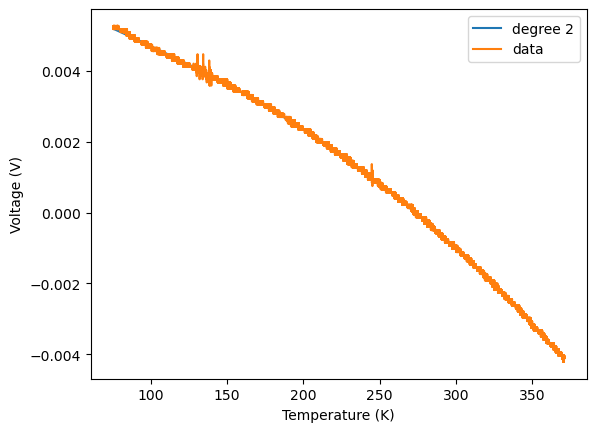

In [71]:
plt.figure()

for i, p in enumerate(polynomials_k_k):
    plt.plot(Kupfer_Konstantan['Temperature_filtered_lowpass'][:], np.polyval(p, Kupfer_Konstantan['Temperature_filtered_lowpass'][:]), label='degree ' + str(i+2))
plt.plot(Kupfer_Konstantan['Temperature_filtered_lowpass'][:], Kupfer_Konstantan['V_T'][:], label='data')
plt.xlabel('Temperature (K)')
plt.ylabel('Voltage (V)')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


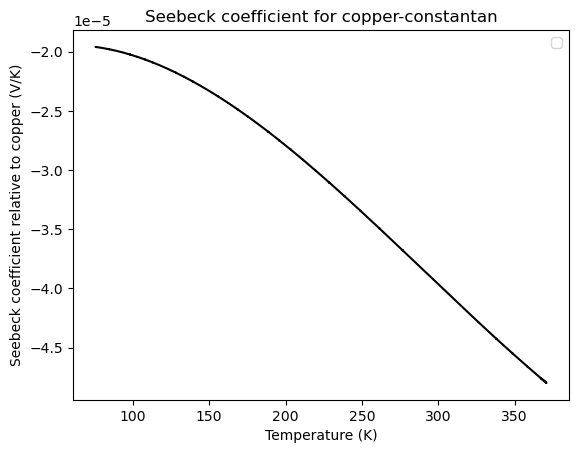

In [72]:
plt.figure()

for i, p in enumerate(polynomials_k_k):

    # the derivative of the polynomial fit
    dp = np.polyder(p)

    # plot the derivative of the polynomial fit
    #the line color should be shades of gray
    # the line color should get darker as the degree of the polynomial increases
    plt.plot(Kupfer_Konstantan['Temperature_filtered_lowpass'], np.polyval(dp, Kupfer_Konstantan['Temperature_filtered_lowpass']), color=(i/10, i/10, i/10))

plt.xlabel('Temperature (K)')
plt.ylabel('Seebeck coefficient relative to copper (V/K)')
plt.title('Seebeck coefficient for copper-constantan')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


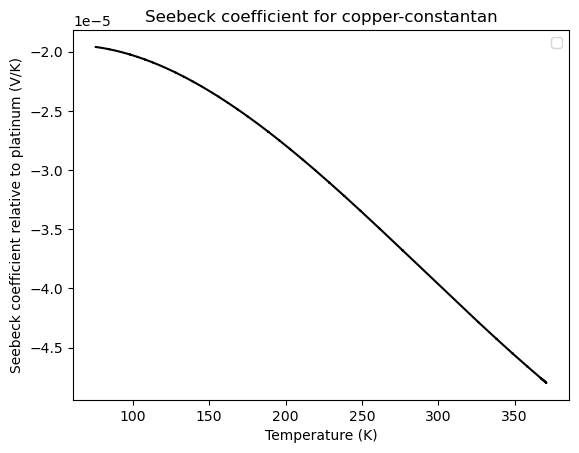

In [73]:
plt.figure()

for i, p in enumerate(polynomials_k_k):

    # the derivative of the polynomial fit
    dp = np.polyder(p)

    # plot the derivative of the polynomial fit
    #the line color should be shades of gray
    # the line color should get darker as the degree of the polynomial increases
    plt.plot(Kupfer_Konstantan['Temperature_filtered_lowpass'], np.polyval(dp, Kupfer_Konstantan['Temperature_filtered_lowpass']), color=(i/10, i/10, i/10))

plt.xlabel('Temperature (K)')
plt.ylabel('Seebeck coefficient relative to platinum (V/K)')
plt.title('Seebeck coefficient for copper-constantan')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


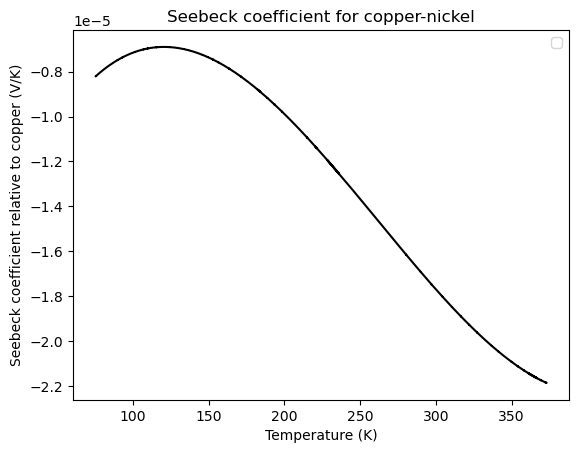

In [75]:
plt.figure()

for i, p in enumerate(polynomials_k_n):

    # the derivative of the polynomial fit
    dp = np.polyder(p)

    # plot the derivative of the polynomial fit
    #the line color should be shades of gray
    # the line color should get darker as the degree of the polynomial increases
    plt.plot(Kupfer_Nickel['Temperature_filtered_lowpass'], np.polyval(dp, Kupfer_Nickel['Temperature_filtered_lowpass']), color=(i/10, i/10, i/10))

plt.xlabel('Temperature (K)')
plt.ylabel('Seebeck coefficient relative to copper (V/K)')
plt.title('Seebeck coefficient for copper-nickel')
plt.legend()
plt.show()